In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch_fidelity import calculate_metrics
import numpy as np

In [3]:
# **Device Configuration**
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [4]:
# Hyperparameters
latent_dim = 100
img_size = 28
channels = 1
batch_size = 64
num_epochs = 300  
learning_rate_g = 0.0002  # Reduced learning rate for generator
learning_rate_d = 0.0003  # Reduced learning rate for discriminator
#weight_clip = 0.01  # Weight clipping value
lambda_gp = 1  # Gradient penalty coefficient

In [5]:
# **Data Loading**
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize images to [-1, 1]
])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True if device != "mps" else False)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),  # Replaced ReLU with LeakyReLU
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),  # Replaced ReLU with LeakyReLU
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),  # Replaced ReLU with LeakyReLU
            nn.Linear(512, img_size * img_size * channels),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), channels, img_size, img_size)
        return img

In [7]:
# **Discriminator (Critic) for WGAN**
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_size * img_size * channels, 512),
            nn.LeakyReLU(0.2),  # Replaced ReLU with LeakyReLU
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),  # Replaced ReLU with LeakyReLU
            nn.Linear(256, 1)
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)  # No Sigmoid in WGAN
        return validity

In [8]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    # Random weight term for interpolation
    alpha = torch.randn(real_samples.size(0), 1, 1, 1, device=device)  # Shape [batch_size, 1, 1, 1]
    alpha = alpha.expand_as(real_samples)  # Now it will match the shape of real_samples: [batch_size, 1, 28, 28]

    interpolates = alpha * real_samples + (1 - alpha) * fake_samples
    interpolates.requires_grad_(True)

    d_interpolates = discriminator(interpolates)
    gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates,
                                    grad_outputs=torch.ones(d_interpolates.size(), device=device),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()  # L2 norm
    return gradient_penalty


In [9]:
# **Model Initialization**
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [10]:
# **Loss and Optimizers**
criterion = nn.BCEWithLogitsLoss()  # Using BCEWithLogitsLoss for unscaled discriminator output
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate_g, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate_d, betas=(0.5, 0.999))

Epoch [1/300], D Loss: 0.6900, G Loss: 1.9732
Epoch [2/300], D Loss: 0.7183, G Loss: 1.9793
Epoch [3/300], D Loss: 0.7113, G Loss: 2.0621
Epoch [4/300], D Loss: 0.7229, G Loss: 1.9255
Epoch [5/300], D Loss: 0.7698, G Loss: 1.9201
Epoch [6/300], D Loss: 0.7657, G Loss: 1.9136
Epoch [7/300], D Loss: 0.7529, G Loss: 1.5797
Epoch [8/300], D Loss: 0.7317, G Loss: 1.7701
Epoch [9/300], D Loss: 0.7909, G Loss: 1.7983
Epoch [10/300], D Loss: 0.7859, G Loss: 2.0212


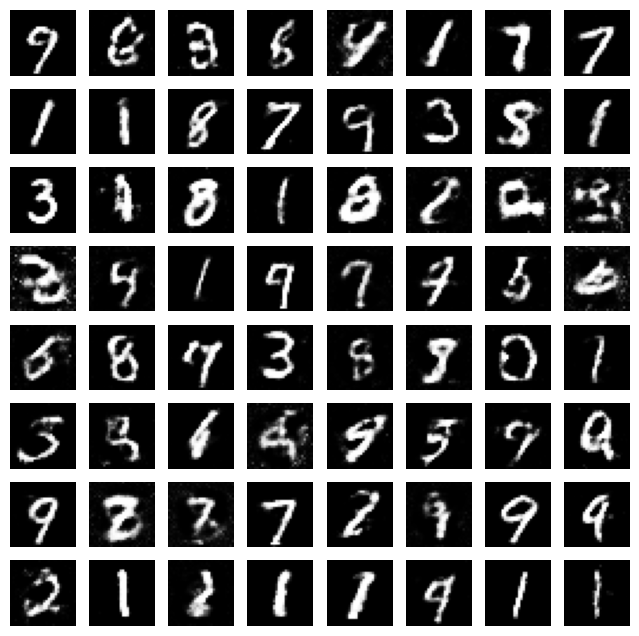

Epoch [11/300], D Loss: 0.7919, G Loss: 1.6672
Epoch [12/300], D Loss: 0.7627, G Loss: 1.8334
Epoch [13/300], D Loss: 0.8473, G Loss: 2.1126
Epoch [14/300], D Loss: 0.7545, G Loss: 1.7642
Epoch [15/300], D Loss: 0.7700, G Loss: 1.7203
Epoch [16/300], D Loss: 0.7591, G Loss: 1.6284
Epoch [17/300], D Loss: 0.7531, G Loss: 1.6330
Epoch [18/300], D Loss: 0.7663, G Loss: 1.7981
Epoch [19/300], D Loss: 0.7622, G Loss: 1.6471
Epoch [20/300], D Loss: 0.8171, G Loss: 1.6680


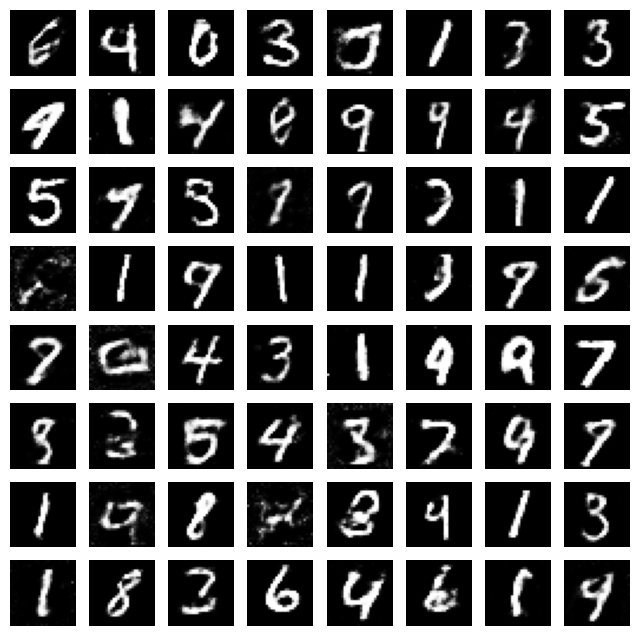

Epoch [21/300], D Loss: 0.7560, G Loss: 1.7226
Epoch [22/300], D Loss: 0.8364, G Loss: 1.8644
Epoch [23/300], D Loss: 0.7960, G Loss: 1.9449
Epoch [24/300], D Loss: 0.7936, G Loss: 1.8171
Epoch [25/300], D Loss: 0.7785, G Loss: 1.6161
Epoch [26/300], D Loss: 0.8230, G Loss: 1.7818
Epoch [27/300], D Loss: 0.8394, G Loss: 1.5198
Epoch [28/300], D Loss: 0.8016, G Loss: 1.8283
Epoch [29/300], D Loss: 0.7900, G Loss: 1.8815
Epoch [30/300], D Loss: 0.8184, G Loss: 1.4485


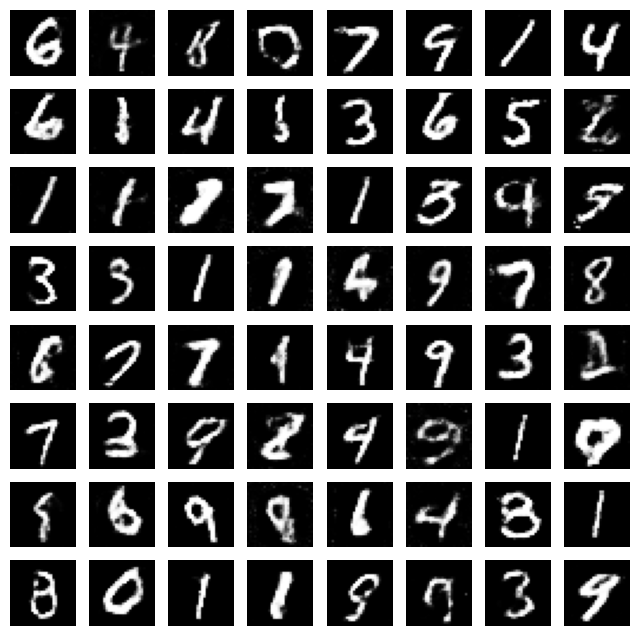

Epoch [31/300], D Loss: 0.8004, G Loss: 1.8341
Epoch [32/300], D Loss: 0.8781, G Loss: 1.4990
Epoch [33/300], D Loss: 0.7901, G Loss: 2.0346
Epoch [34/300], D Loss: 0.8142, G Loss: 1.3202
Epoch [35/300], D Loss: 0.8223, G Loss: 1.7167
Epoch [36/300], D Loss: 0.7821, G Loss: 1.4918
Epoch [37/300], D Loss: 0.7803, G Loss: 1.4619
Epoch [38/300], D Loss: 0.8305, G Loss: 1.6517
Epoch [39/300], D Loss: 0.8033, G Loss: 1.5678
Epoch [40/300], D Loss: 0.8380, G Loss: 1.8764


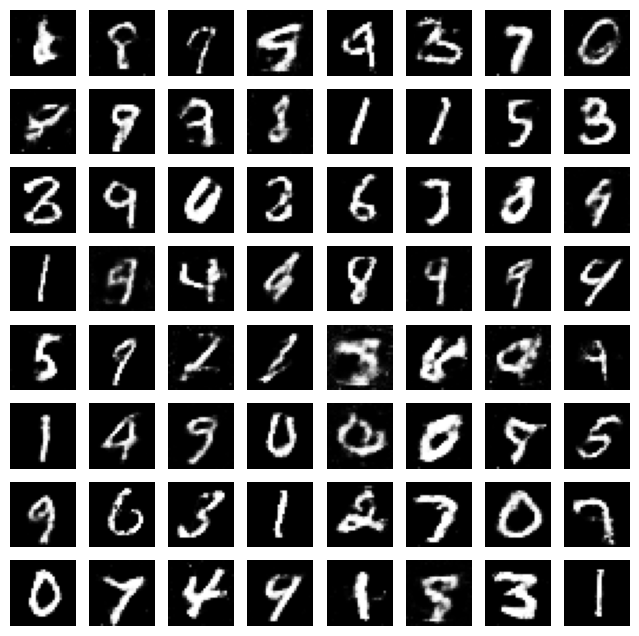

Epoch [41/300], D Loss: 0.7990, G Loss: 1.4007
Epoch [42/300], D Loss: 0.8000, G Loss: 1.5900
Epoch [43/300], D Loss: 0.8023, G Loss: 1.7678
Epoch [44/300], D Loss: 0.7607, G Loss: 1.6612
Epoch [45/300], D Loss: 0.8763, G Loss: 1.7633
Epoch [46/300], D Loss: 0.7999, G Loss: 1.7114
Epoch [47/300], D Loss: 0.8278, G Loss: 1.6169
Epoch [48/300], D Loss: 0.8151, G Loss: 1.5239
Epoch [49/300], D Loss: 0.8173, G Loss: 1.6639
Epoch [50/300], D Loss: 0.8217, G Loss: 1.6649


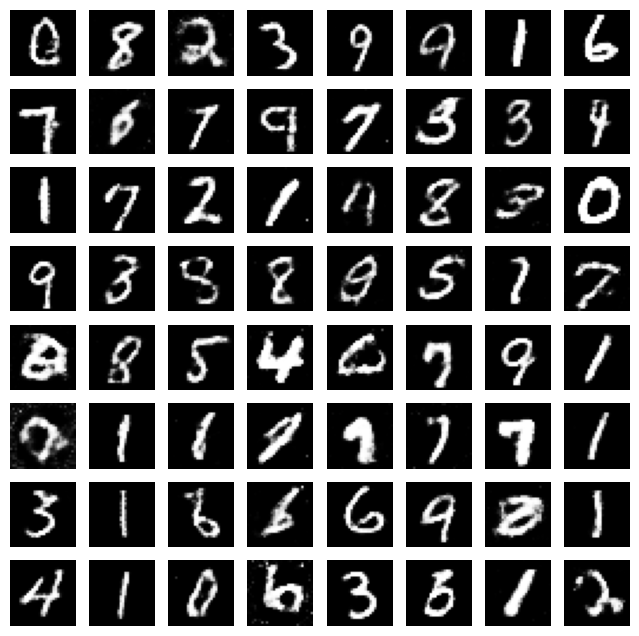

Epoch [51/300], D Loss: 0.8213, G Loss: 1.7263
Epoch [52/300], D Loss: 0.8522, G Loss: 1.5720
Epoch [53/300], D Loss: 0.9011, G Loss: 1.6369
Epoch [54/300], D Loss: 0.8240, G Loss: 1.5465
Epoch [55/300], D Loss: 0.8387, G Loss: 1.7140
Epoch [56/300], D Loss: 0.8499, G Loss: 1.4232
Epoch [57/300], D Loss: 0.8499, G Loss: 1.6127
Epoch [58/300], D Loss: 0.8059, G Loss: 1.6771
Epoch [59/300], D Loss: 0.8147, G Loss: 1.6312
Epoch [60/300], D Loss: 0.8591, G Loss: 1.5694


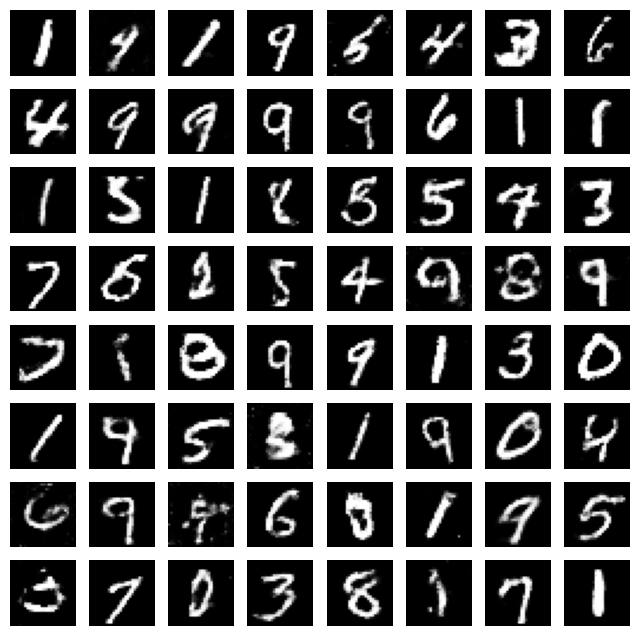

Epoch [61/300], D Loss: 0.8117, G Loss: 1.6318
Epoch [62/300], D Loss: 0.8675, G Loss: 1.4376
Epoch [63/300], D Loss: 0.8420, G Loss: 1.4404
Epoch [64/300], D Loss: 0.8657, G Loss: 1.4069
Epoch [65/300], D Loss: 0.8218, G Loss: 1.4437
Epoch [66/300], D Loss: 0.8818, G Loss: 1.5065
Epoch [67/300], D Loss: 0.8244, G Loss: 1.4714
Epoch [68/300], D Loss: 0.8737, G Loss: 1.6888
Epoch [69/300], D Loss: 0.8566, G Loss: 1.5159
Epoch [70/300], D Loss: 0.8358, G Loss: 1.6119


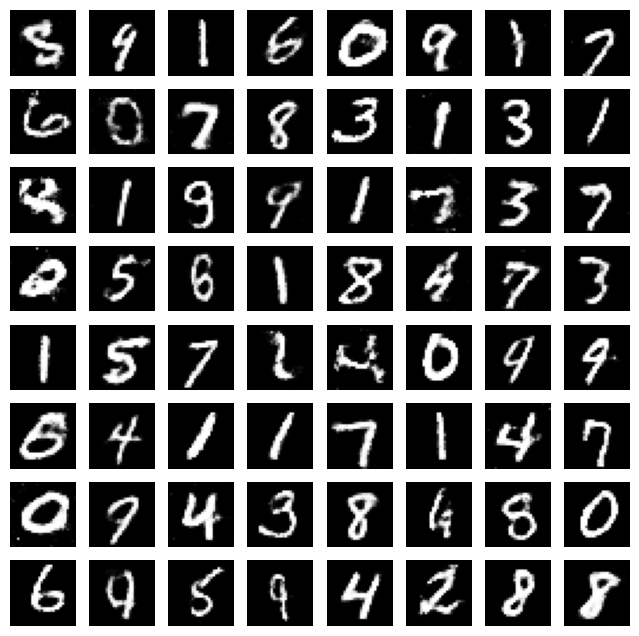

Epoch [71/300], D Loss: 0.8044, G Loss: 1.6577
Epoch [72/300], D Loss: 0.8837, G Loss: 1.4909
Epoch [73/300], D Loss: 0.8273, G Loss: 1.3870
Epoch [74/300], D Loss: 0.8425, G Loss: 1.6644
Epoch [75/300], D Loss: 0.7960, G Loss: 1.4755
Epoch [76/300], D Loss: 0.8417, G Loss: 1.3976
Epoch [77/300], D Loss: 0.8309, G Loss: 1.5054
Epoch [78/300], D Loss: 0.8290, G Loss: 1.4311
Epoch [79/300], D Loss: 0.8658, G Loss: 1.5813
Epoch [80/300], D Loss: 0.8691, G Loss: 1.4291


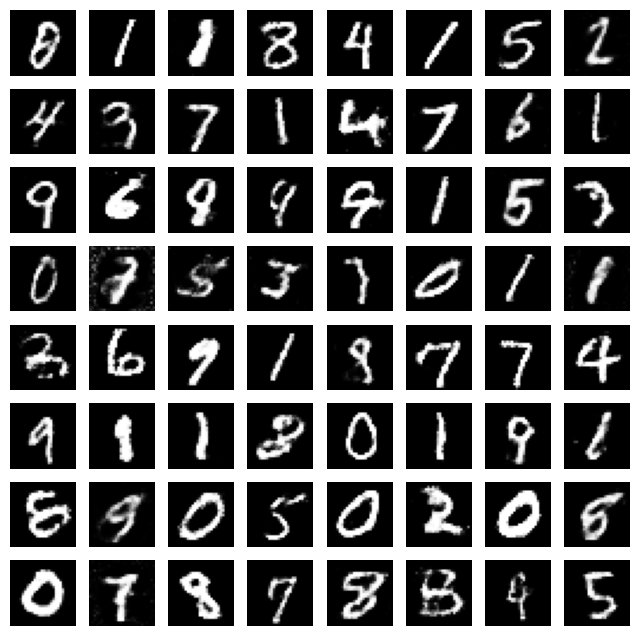

Epoch [81/300], D Loss: 0.8079, G Loss: 1.5329
Epoch [82/300], D Loss: 0.8007, G Loss: 1.5615
Epoch [83/300], D Loss: 0.8220, G Loss: 1.7208
Epoch [84/300], D Loss: 0.8190, G Loss: 1.3973
Epoch [85/300], D Loss: 0.8216, G Loss: 1.3832
Epoch [86/300], D Loss: 0.8191, G Loss: 1.6330
Epoch [87/300], D Loss: 0.8487, G Loss: 1.5111
Epoch [88/300], D Loss: 0.8986, G Loss: 1.5546
Epoch [89/300], D Loss: 0.8262, G Loss: 1.3508
Epoch [90/300], D Loss: 0.8386, G Loss: 1.3638


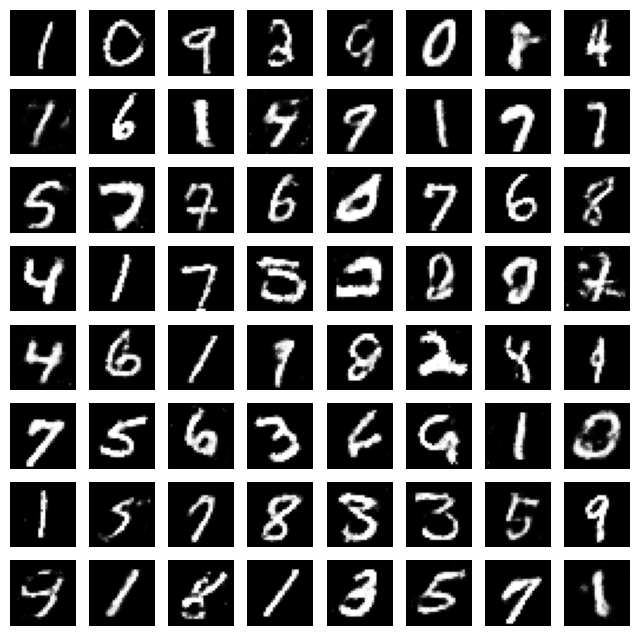

Epoch [91/300], D Loss: 0.8099, G Loss: 1.4079
Epoch [92/300], D Loss: 0.8498, G Loss: 1.4728
Epoch [93/300], D Loss: 0.8527, G Loss: 1.7039
Epoch [94/300], D Loss: 0.8334, G Loss: 1.4059
Epoch [95/300], D Loss: 0.8182, G Loss: 1.4458
Epoch [96/300], D Loss: 0.8710, G Loss: 1.3533
Epoch [97/300], D Loss: 0.7912, G Loss: 1.4840
Epoch [98/300], D Loss: 0.8730, G Loss: 1.5273
Epoch [99/300], D Loss: 0.8810, G Loss: 1.6398
Epoch [100/300], D Loss: 0.8667, G Loss: 1.4702


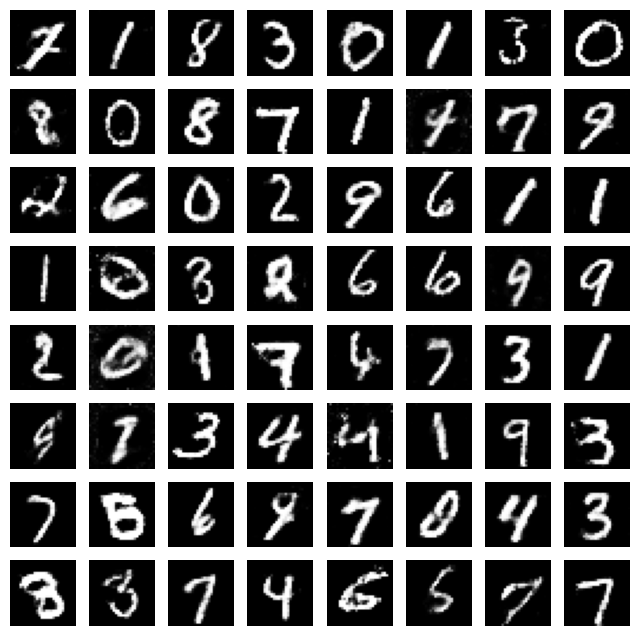

Epoch [101/300], D Loss: 0.8083, G Loss: 1.3891
Epoch [102/300], D Loss: 0.8223, G Loss: 1.5131
Epoch [103/300], D Loss: 0.8104, G Loss: 1.4754
Epoch [104/300], D Loss: 0.9022, G Loss: 1.4783
Epoch [105/300], D Loss: 0.8153, G Loss: 1.4142
Epoch [106/300], D Loss: 0.8092, G Loss: 1.5470
Epoch [107/300], D Loss: 0.8111, G Loss: 1.4196
Epoch [108/300], D Loss: 0.8672, G Loss: 1.6593
Epoch [109/300], D Loss: 0.8369, G Loss: 1.5447
Epoch [110/300], D Loss: 0.8719, G Loss: 1.4519


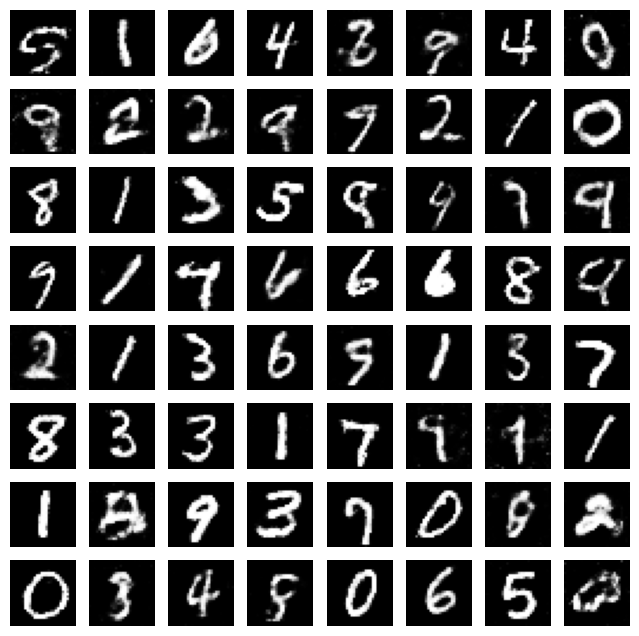

Epoch [111/300], D Loss: 0.8346, G Loss: 1.4844
Epoch [112/300], D Loss: 0.8284, G Loss: 1.5448
Epoch [113/300], D Loss: 0.8739, G Loss: 1.4807
Epoch [114/300], D Loss: 0.8434, G Loss: 1.4559
Epoch [115/300], D Loss: 0.8389, G Loss: 1.5504
Epoch [116/300], D Loss: 0.8651, G Loss: 1.5314
Epoch [117/300], D Loss: 0.8825, G Loss: 1.5505
Epoch [118/300], D Loss: 0.8298, G Loss: 1.5197
Epoch [119/300], D Loss: 0.8470, G Loss: 1.2482
Epoch [120/300], D Loss: 0.9139, G Loss: 1.5475


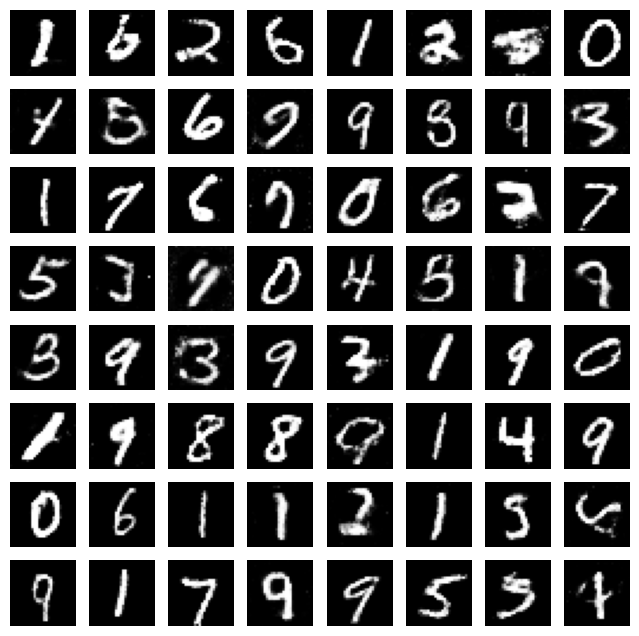

Epoch [121/300], D Loss: 0.8224, G Loss: 1.6772
Epoch [122/300], D Loss: 0.9189, G Loss: 1.6473
Epoch [123/300], D Loss: 0.8367, G Loss: 1.5707
Epoch [124/300], D Loss: 0.8350, G Loss: 1.5437
Epoch [125/300], D Loss: 0.8024, G Loss: 1.5835
Epoch [126/300], D Loss: 0.8199, G Loss: 1.6181
Epoch [127/300], D Loss: 0.8176, G Loss: 1.4648
Epoch [128/300], D Loss: 0.7901, G Loss: 1.5668
Epoch [129/300], D Loss: 0.8477, G Loss: 1.3422
Epoch [130/300], D Loss: 0.8220, G Loss: 1.4852


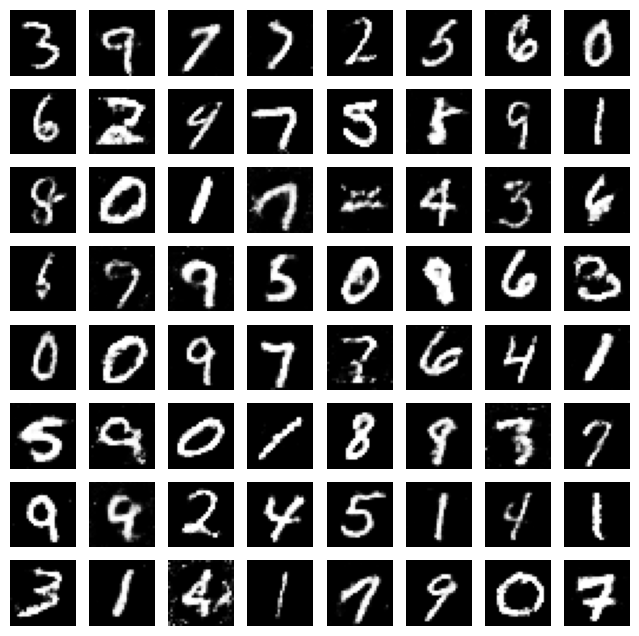

Epoch [131/300], D Loss: 0.8789, G Loss: 1.3963
Epoch [132/300], D Loss: 0.8432, G Loss: 1.5870
Epoch [133/300], D Loss: 0.8583, G Loss: 1.5280
Epoch [134/300], D Loss: 0.8584, G Loss: 1.5568
Epoch [135/300], D Loss: 0.8644, G Loss: 1.6135
Epoch [136/300], D Loss: 0.8386, G Loss: 1.3030
Epoch [137/300], D Loss: 0.8618, G Loss: 1.4376
Epoch [138/300], D Loss: 0.8887, G Loss: 1.4826
Epoch [139/300], D Loss: 0.8654, G Loss: 1.4941
Epoch [140/300], D Loss: 0.8515, G Loss: 1.3381


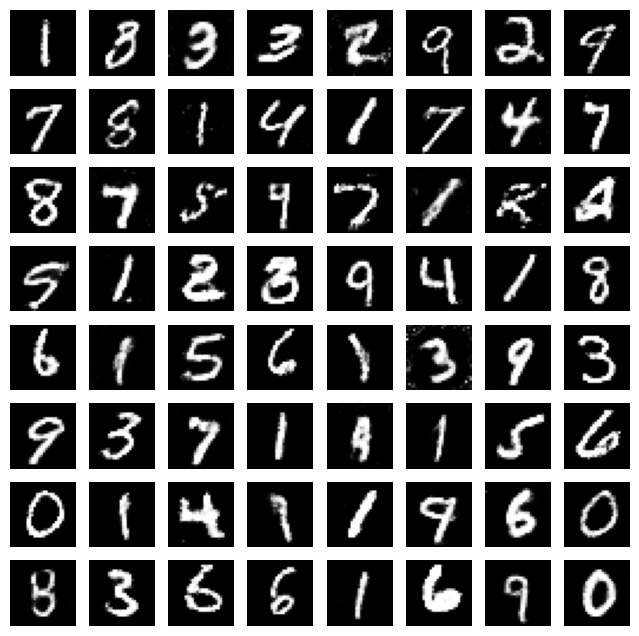

Epoch [141/300], D Loss: 0.7886, G Loss: 1.8049
Epoch [142/300], D Loss: 0.8087, G Loss: 1.5447
Epoch [143/300], D Loss: 0.8476, G Loss: 1.4467
Epoch [144/300], D Loss: 0.8541, G Loss: 1.5266
Epoch [145/300], D Loss: 0.8848, G Loss: 1.4504
Epoch [146/300], D Loss: 0.8493, G Loss: 1.6645
Epoch [147/300], D Loss: 0.8866, G Loss: 1.4824
Epoch [148/300], D Loss: 0.8255, G Loss: 1.4873
Epoch [149/300], D Loss: 0.8693, G Loss: 1.3831
Epoch [150/300], D Loss: 0.8886, G Loss: 1.3580


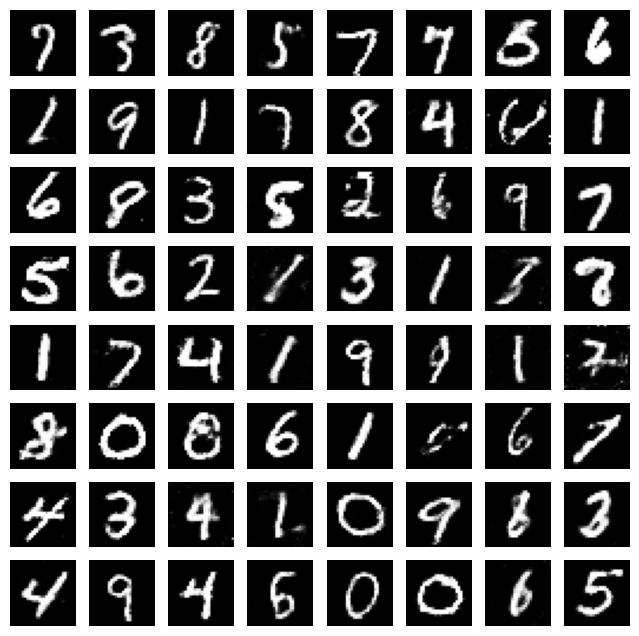

Epoch [151/300], D Loss: 0.8014, G Loss: 1.5089
Epoch [152/300], D Loss: 0.8259, G Loss: 1.3154
Epoch [153/300], D Loss: 0.7981, G Loss: 1.4553
Epoch [154/300], D Loss: 0.8698, G Loss: 1.3663
Epoch [155/300], D Loss: 0.8270, G Loss: 1.4888
Epoch [156/300], D Loss: 0.8632, G Loss: 1.4246
Epoch [157/300], D Loss: 0.8051, G Loss: 1.5112
Epoch [158/300], D Loss: 0.9225, G Loss: 1.6177
Epoch [159/300], D Loss: 0.8260, G Loss: 1.5257
Epoch [160/300], D Loss: 0.9191, G Loss: 1.4437


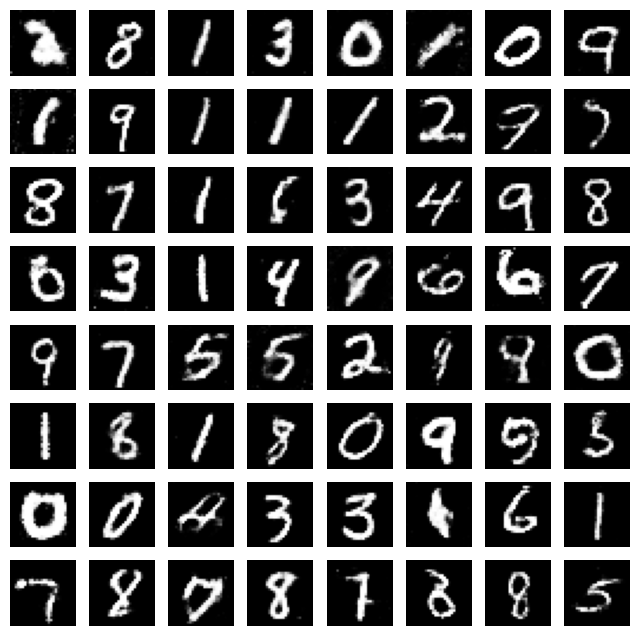

Epoch [161/300], D Loss: 0.8732, G Loss: 1.4143
Epoch [162/300], D Loss: 0.8533, G Loss: 1.3493
Epoch [163/300], D Loss: 0.8597, G Loss: 1.4890
Epoch [164/300], D Loss: 0.8403, G Loss: 1.6106
Epoch [165/300], D Loss: 0.8444, G Loss: 1.5034
Epoch [166/300], D Loss: 0.8568, G Loss: 1.4111
Epoch [167/300], D Loss: 0.8701, G Loss: 1.4504
Epoch [168/300], D Loss: 0.8368, G Loss: 1.7301
Epoch [169/300], D Loss: 0.8971, G Loss: 1.5945
Epoch [170/300], D Loss: 0.8936, G Loss: 1.4084


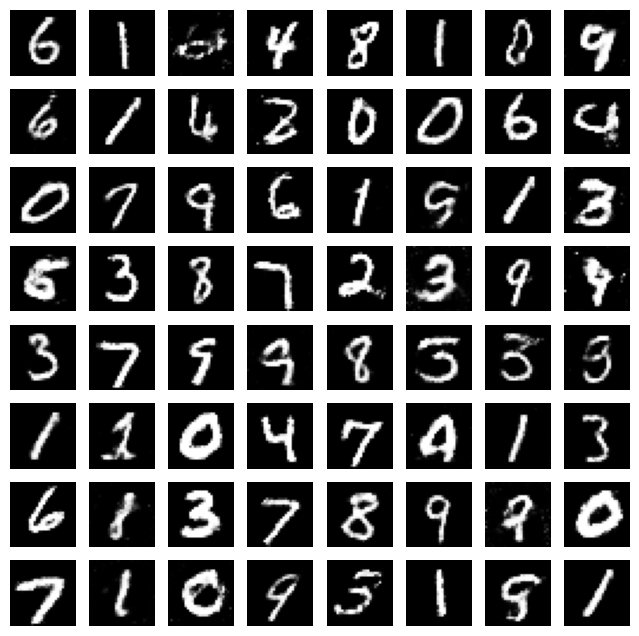

Epoch [171/300], D Loss: 0.8450, G Loss: 1.5085
Epoch [172/300], D Loss: 0.8513, G Loss: 1.6318
Epoch [173/300], D Loss: 0.8118, G Loss: 1.4110
Epoch [174/300], D Loss: 0.8275, G Loss: 1.7051
Epoch [175/300], D Loss: 0.8558, G Loss: 1.5637
Epoch [176/300], D Loss: 0.8617, G Loss: 1.5445
Epoch [177/300], D Loss: 0.7819, G Loss: 1.5467
Epoch [178/300], D Loss: 0.8557, G Loss: 1.3678
Epoch [179/300], D Loss: 0.8370, G Loss: 1.3887
Epoch [180/300], D Loss: 0.8450, G Loss: 1.4915


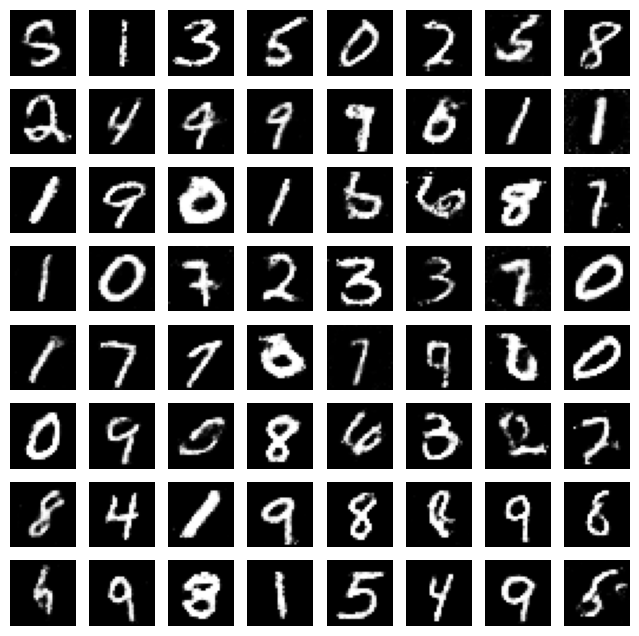

Epoch [181/300], D Loss: 0.8383, G Loss: 1.4053
Epoch [182/300], D Loss: 0.8568, G Loss: 1.5472
Epoch [183/300], D Loss: 0.8610, G Loss: 1.6089
Epoch [184/300], D Loss: 0.8807, G Loss: 1.6448
Epoch [185/300], D Loss: 0.8376, G Loss: 1.4902
Epoch [186/300], D Loss: 0.8182, G Loss: 1.4558
Epoch [187/300], D Loss: 0.8225, G Loss: 1.2811
Epoch [188/300], D Loss: 0.8763, G Loss: 1.5261
Epoch [189/300], D Loss: 0.8698, G Loss: 1.5783
Epoch [190/300], D Loss: 0.8740, G Loss: 1.4847


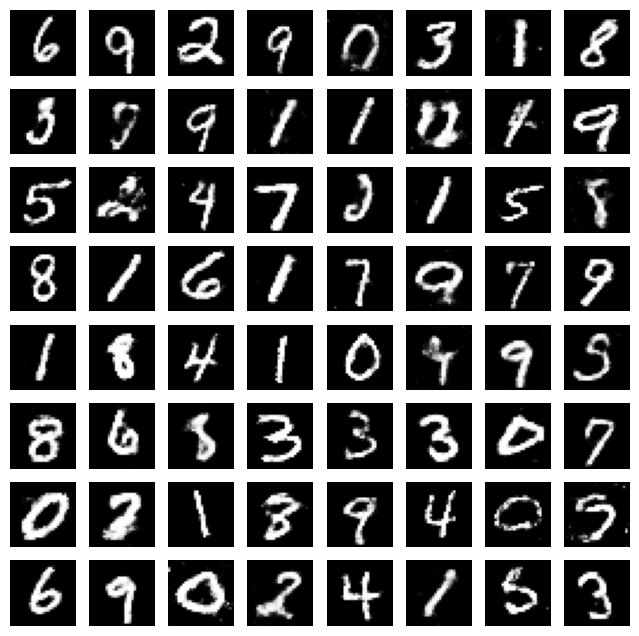

Epoch [191/300], D Loss: 0.8244, G Loss: 1.5537
Epoch [192/300], D Loss: 0.8363, G Loss: 1.5621
Epoch [193/300], D Loss: 0.8367, G Loss: 1.2914
Epoch [194/300], D Loss: 0.8819, G Loss: 1.3477
Epoch [195/300], D Loss: 0.8197, G Loss: 1.4681
Epoch [196/300], D Loss: 0.8192, G Loss: 1.3441
Epoch [197/300], D Loss: 0.9250, G Loss: 1.3622
Epoch [198/300], D Loss: 0.8732, G Loss: 1.4598
Epoch [199/300], D Loss: 0.8830, G Loss: 1.7099
Epoch [200/300], D Loss: 0.8594, G Loss: 1.3812


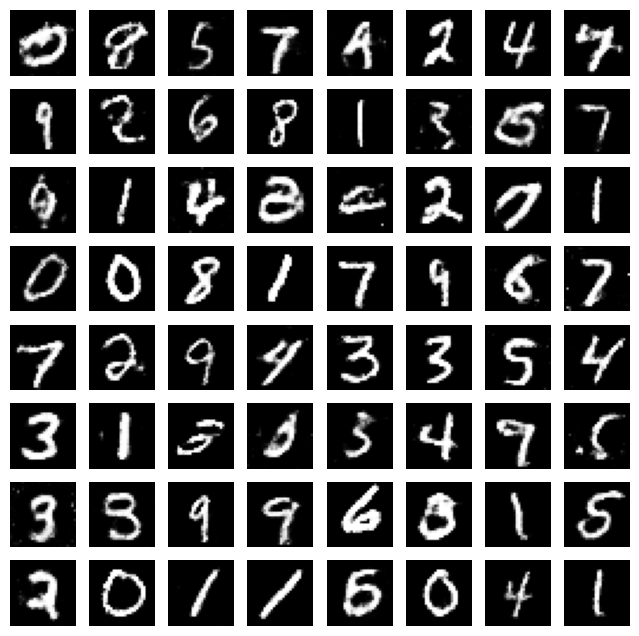

Epoch [201/300], D Loss: 0.8642, G Loss: 1.4429
Epoch [202/300], D Loss: 0.8410, G Loss: 1.5086
Epoch [203/300], D Loss: 0.8277, G Loss: 1.5999
Epoch [204/300], D Loss: 0.9143, G Loss: 1.4431
Epoch [205/300], D Loss: 0.8390, G Loss: 1.3873
Epoch [206/300], D Loss: 0.8107, G Loss: 1.4052
Epoch [207/300], D Loss: 0.8561, G Loss: 1.4682
Epoch [208/300], D Loss: 0.8217, G Loss: 1.3337
Epoch [209/300], D Loss: 0.8561, G Loss: 1.4466
Epoch [210/300], D Loss: 0.8709, G Loss: 1.4316


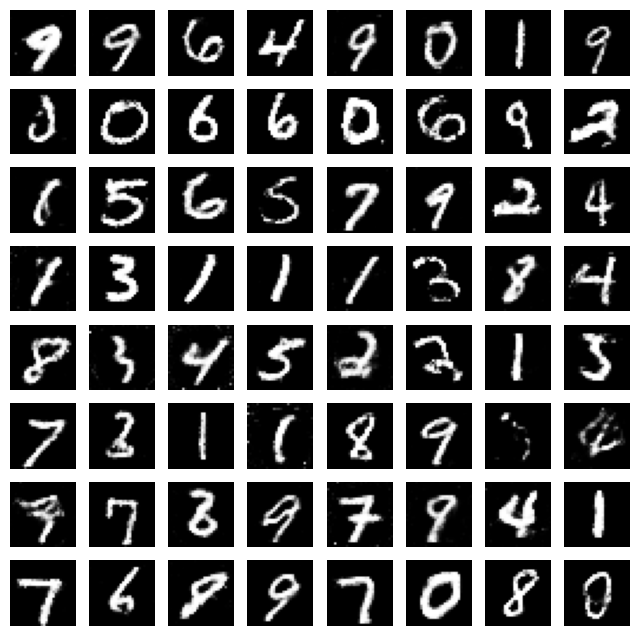

Epoch [211/300], D Loss: 0.8483, G Loss: 1.4342
Epoch [212/300], D Loss: 0.8914, G Loss: 1.3309
Epoch [213/300], D Loss: 0.8264, G Loss: 1.5016
Epoch [214/300], D Loss: 0.8372, G Loss: 1.6728
Epoch [215/300], D Loss: 0.8509, G Loss: 1.5430
Epoch [216/300], D Loss: 0.8585, G Loss: 1.3992
Epoch [217/300], D Loss: 0.8250, G Loss: 1.4299
Epoch [218/300], D Loss: 0.8473, G Loss: 1.5033
Epoch [219/300], D Loss: 0.8611, G Loss: 1.4135
Epoch [220/300], D Loss: 0.8263, G Loss: 1.4704


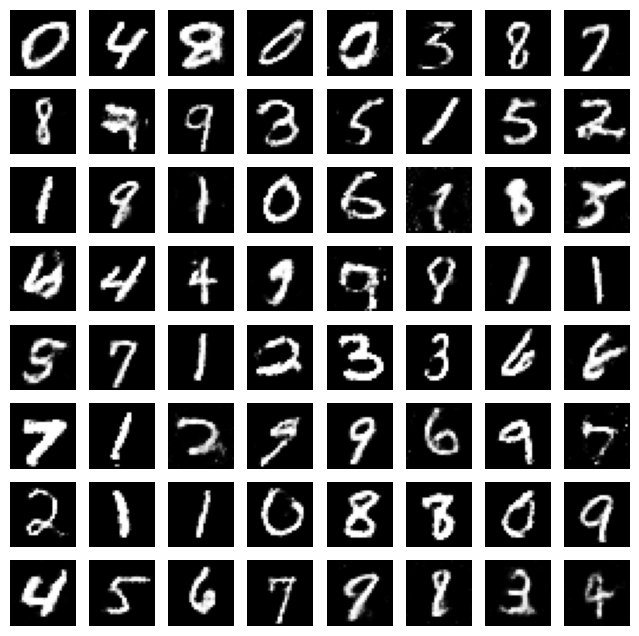

Epoch [221/300], D Loss: 0.8187, G Loss: 1.7615
Epoch [222/300], D Loss: 0.8508, G Loss: 1.5265
Epoch [223/300], D Loss: 0.8832, G Loss: 1.5239
Epoch [224/300], D Loss: 0.8664, G Loss: 1.4299
Epoch [225/300], D Loss: 0.8468, G Loss: 1.5602
Epoch [226/300], D Loss: 0.8415, G Loss: 1.3740
Epoch [227/300], D Loss: 0.8765, G Loss: 1.4113
Epoch [228/300], D Loss: 0.8293, G Loss: 1.3850
Epoch [229/300], D Loss: 0.8473, G Loss: 1.4793
Epoch [230/300], D Loss: 0.8396, G Loss: 1.5579


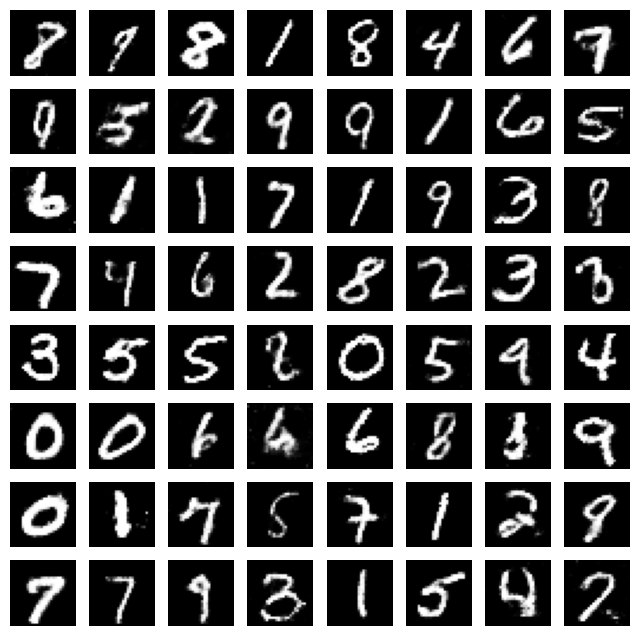

Epoch [231/300], D Loss: 0.8385, G Loss: 1.4307
Epoch [232/300], D Loss: 0.8901, G Loss: 1.6038
Epoch [233/300], D Loss: 0.8642, G Loss: 1.4354
Epoch [234/300], D Loss: 0.8606, G Loss: 1.4785
Epoch [235/300], D Loss: 0.8565, G Loss: 1.2716
Epoch [236/300], D Loss: 0.8858, G Loss: 1.4324
Epoch [237/300], D Loss: 0.8206, G Loss: 1.5737
Epoch [238/300], D Loss: 0.8507, G Loss: 1.4340
Epoch [239/300], D Loss: 0.8761, G Loss: 1.4921
Epoch [240/300], D Loss: 0.8685, G Loss: 1.5964


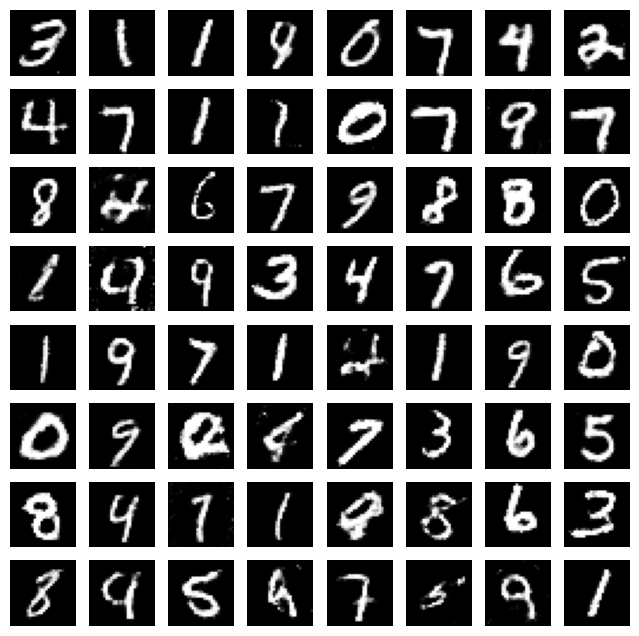

Epoch [241/300], D Loss: 0.8997, G Loss: 1.6008
Epoch [242/300], D Loss: 0.8934, G Loss: 1.3214
Epoch [243/300], D Loss: 0.8753, G Loss: 1.4492
Epoch [244/300], D Loss: 0.8807, G Loss: 1.3974
Epoch [245/300], D Loss: 0.8671, G Loss: 1.4048
Epoch [246/300], D Loss: 0.8575, G Loss: 1.6072
Epoch [247/300], D Loss: 0.8649, G Loss: 1.4562
Epoch [248/300], D Loss: 0.8824, G Loss: 1.5518
Epoch [249/300], D Loss: 0.8339, G Loss: 1.7154
Epoch [250/300], D Loss: 0.8070, G Loss: 1.4863


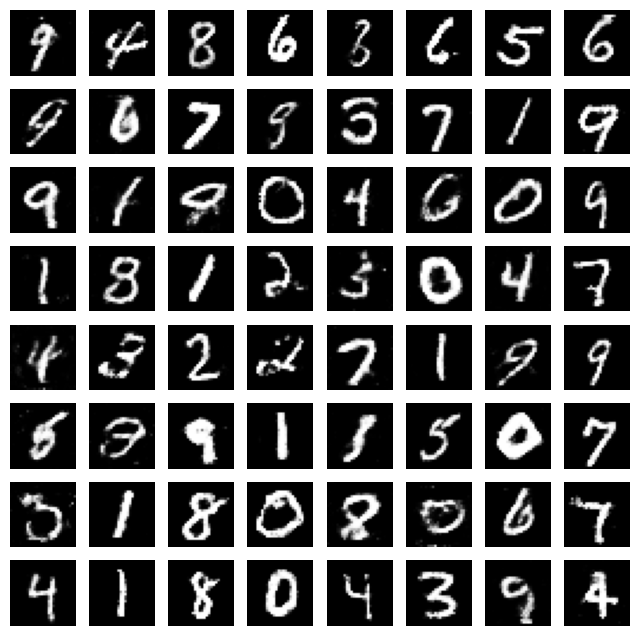

Epoch [251/300], D Loss: 0.8764, G Loss: 1.4967
Epoch [252/300], D Loss: 0.8536, G Loss: 1.3522
Epoch [253/300], D Loss: 0.8203, G Loss: 1.2516
Epoch [254/300], D Loss: 0.8260, G Loss: 1.6410
Epoch [255/300], D Loss: 0.8164, G Loss: 1.3764
Epoch [256/300], D Loss: 0.8334, G Loss: 1.3543
Epoch [257/300], D Loss: 0.8939, G Loss: 1.5415
Epoch [258/300], D Loss: 0.8449, G Loss: 1.5762
Epoch [259/300], D Loss: 0.8481, G Loss: 1.3175
Epoch [260/300], D Loss: 0.8048, G Loss: 1.5121


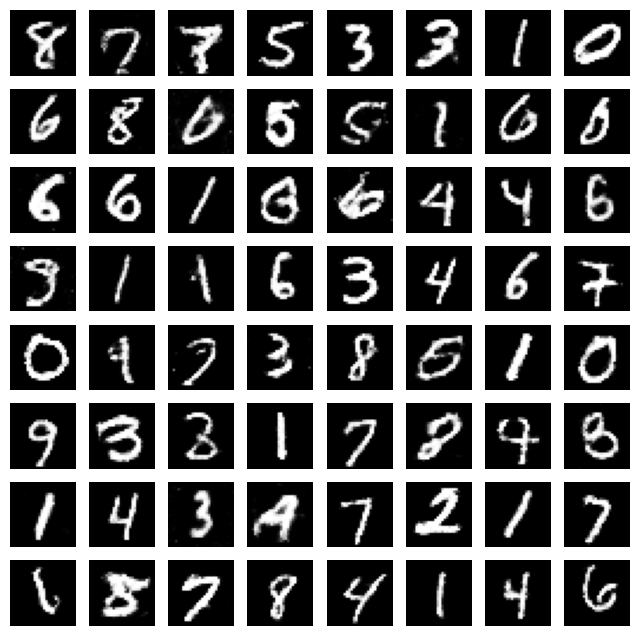

Epoch [261/300], D Loss: 0.8200, G Loss: 1.6040
Epoch [262/300], D Loss: 0.8815, G Loss: 1.4640
Epoch [263/300], D Loss: 0.8646, G Loss: 1.3221
Epoch [264/300], D Loss: 0.8648, G Loss: 1.5174
Epoch [265/300], D Loss: 0.8644, G Loss: 1.3589
Epoch [266/300], D Loss: 0.8676, G Loss: 1.4747
Epoch [267/300], D Loss: 0.8766, G Loss: 1.4972
Epoch [268/300], D Loss: 0.8641, G Loss: 1.2261
Epoch [269/300], D Loss: 0.8563, G Loss: 1.5063
Epoch [270/300], D Loss: 0.8528, G Loss: 1.4380


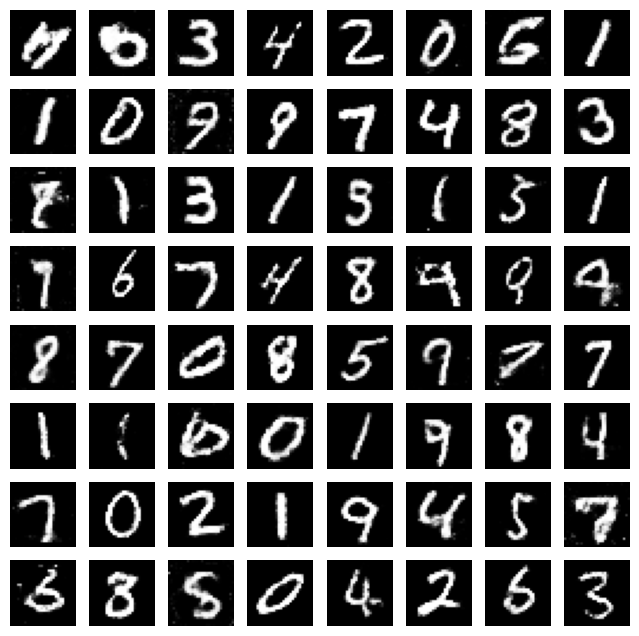

Epoch [271/300], D Loss: 0.8742, G Loss: 1.4648
Epoch [272/300], D Loss: 0.8963, G Loss: 1.4033
Epoch [273/300], D Loss: 0.8925, G Loss: 1.4459
Epoch [274/300], D Loss: 0.7909, G Loss: 1.4202
Epoch [275/300], D Loss: 0.8556, G Loss: 1.6993
Epoch [276/300], D Loss: 0.8486, G Loss: 1.5052
Epoch [277/300], D Loss: 0.8524, G Loss: 1.5995
Epoch [278/300], D Loss: 0.9083, G Loss: 1.2631
Epoch [279/300], D Loss: 0.8000, G Loss: 1.4250
Epoch [280/300], D Loss: 0.8417, G Loss: 1.5037


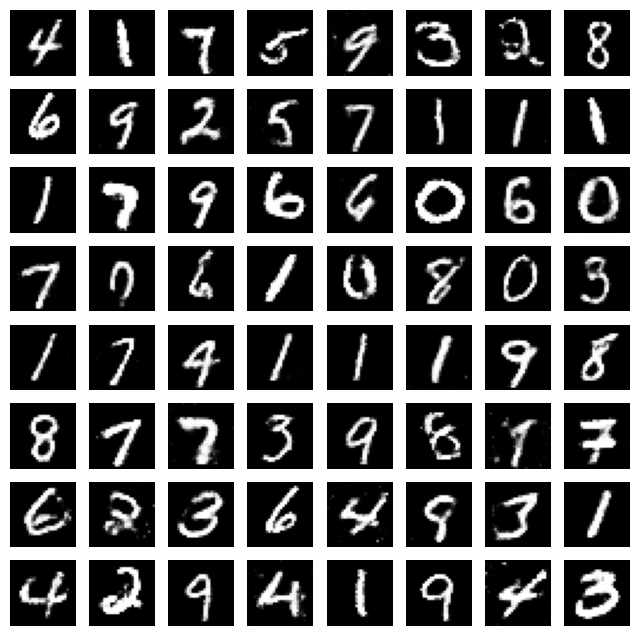

Epoch [281/300], D Loss: 0.8493, G Loss: 1.4398
Epoch [282/300], D Loss: 0.8355, G Loss: 1.4293
Epoch [283/300], D Loss: 0.8779, G Loss: 1.3800
Epoch [284/300], D Loss: 0.7924, G Loss: 1.4627
Epoch [285/300], D Loss: 0.8594, G Loss: 1.5893
Epoch [286/300], D Loss: 0.8960, G Loss: 1.4583
Epoch [287/300], D Loss: 0.8537, G Loss: 1.3820
Epoch [288/300], D Loss: 0.8938, G Loss: 1.5557
Epoch [289/300], D Loss: 0.8939, G Loss: 1.4882
Epoch [290/300], D Loss: 0.8368, G Loss: 1.4448


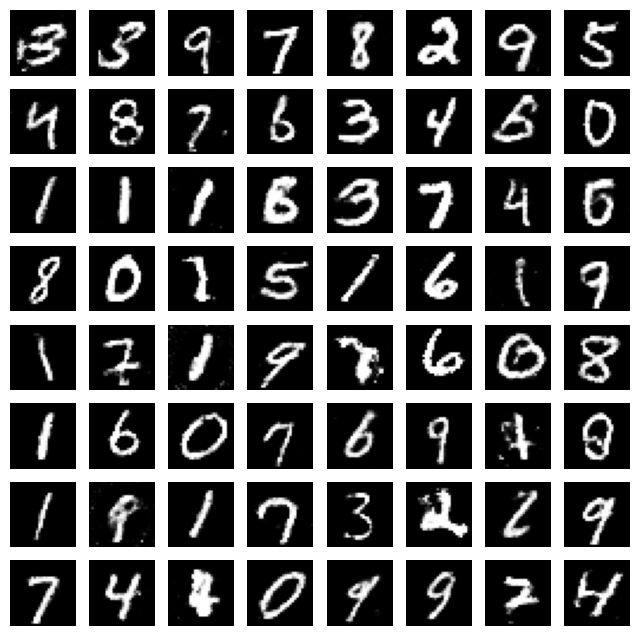

Epoch [291/300], D Loss: 0.8342, G Loss: 1.3354
Epoch [292/300], D Loss: 0.8808, G Loss: 1.2190
Epoch [293/300], D Loss: 0.8677, G Loss: 1.6495
Epoch [294/300], D Loss: 0.8632, G Loss: 1.5419
Epoch [295/300], D Loss: 0.8343, G Loss: 1.2998
Epoch [296/300], D Loss: 0.9149, G Loss: 1.4887
Epoch [297/300], D Loss: 0.9125, G Loss: 1.5162
Epoch [298/300], D Loss: 0.8398, G Loss: 1.4416
Epoch [299/300], D Loss: 0.8821, G Loss: 1.4055
Epoch [300/300], D Loss: 0.8675, G Loss: 1.5434


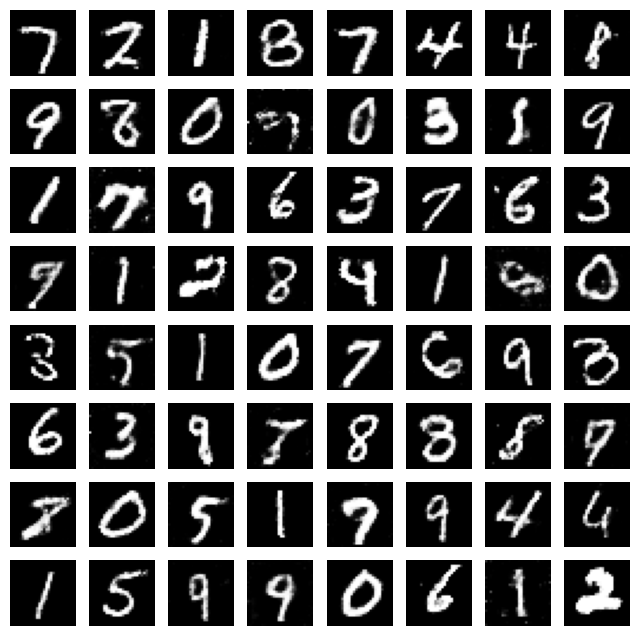

In [11]:
d_steps = 10  # Train discriminator more frequently than the generator (1 times per generator step)

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(data_loader):
        # Prepare labels
        real_labels = torch.full((real_images.size(0), 1), 0.9, device=device)
        fake_labels = torch.full((real_images.size(0), 1), 0.1, device=device)

        # Move real images to device
        real_images = real_images.to(device)

        # Train the discriminator multiple times
        for _ in range(d_steps):
            noise = torch.randn(real_images.size(0), latent_dim, device=device)
            fake_images = generator(noise).detach()  # Detach to avoid updating generator during discriminator training

            # Compute discriminator loss
            real_images += torch.randn_like(real_images) * 0.05  # Optional noise addition
            fake_images += torch.randn_like(fake_images) * 0.05  # Optional noise addition

            d_real_loss = criterion(discriminator(real_images), real_labels)
            d_fake_loss = criterion(discriminator(fake_images), fake_labels)
            d_loss = d_real_loss + d_fake_loss

            # Compute Gradient Penalty
            gradient_penalty = compute_gradient_penalty(discriminator, real_images, fake_images)
            d_loss += lambda_gp * gradient_penalty

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

        # **Train Generator**
        noise = torch.randn(real_images.size(0), latent_dim, device=device)
        fake_images = generator(noise)
        g_loss = criterion(discriminator(fake_images), real_labels)  # Use real_labels to fool D

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    

    # Print losses
    print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    # Save and visualize generated images every 10 epochs
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            noise = torch.randn(64, latent_dim, device=device)
            generated_images = generator(noise).cpu()

            # Plot the images
            fig, axes = plt.subplots(8, 8, figsize=(8, 8))
            for j, ax in enumerate(axes.flatten()):
                ax.imshow(generated_images[j, 0], cmap='gray')
                ax.axis('off')
            plt.show()

In [14]:
# Save generator and discriminator
torch.save(generator.state_dict(), 'generator_model.pth')
torch.save(discriminator.state_dict(), 'discriminator_model.pth')

In [38]:
from torchvision.utils import save_image

In [45]:
import torch
from torch_fidelity import calculate_metrics

# Set device to MPS or CPU fallback
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

# Your existing FID calculation code
metrics = calculate_metrics(
    input1=real_images_dir,
    input2=generated_images_dir,
    cuda=False,  # `torch_fidelity` doesn't yet support MPS directly
    isc=False,   # Inception Score not needed
    fid=True     # Compute FID
)
print(f"FID Score: {metrics['frechet_inception_distance']}")

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "./real_images" with extensions png,jpg,jpeg
Found 704 samples
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.10/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples:   0%|                          | 0/704 [00:00<?, ?samples/s]/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.10/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage c

FID Score: 50.13264416826814


Frechet Inception Distance: 50.13264416826814


In [47]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Evaluate discriminator on test data
def evaluate_discriminator(discriminator, generator, data_loader, device):
    discriminator.eval()
    generator.eval()
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for real_images, _ in data_loader:
            # Prepare real and fake data
            real_images = real_images.to(device)
            batch_size = real_images.size(0)
            noise = torch.randn(batch_size, latent_dim, device=device)
            fake_images = generator(noise)
            
            # Discriminator predictions
            real_preds = discriminator(real_images).view(-1)
            fake_preds = discriminator(fake_images).view(-1)
            
            # Convert to binary predictions
            real_labels = torch.ones_like(real_preds, device=device)  # Label 1 for real
            fake_labels = torch.zeros_like(fake_preds, device=device)  # Label 0 for fake
            
            # Collect predictions and labels
            all_preds.append(torch.cat([real_preds, fake_preds], dim=0).cpu().numpy())
            all_targets.append(torch.cat([real_labels, fake_labels], dim=0).cpu().numpy())
    
    # Concatenate all predictions and labels
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    # Apply thresholding for binary classification
    all_preds_binary = (all_preds > 0.5).astype(int)
    
    # Calculate metrics
    precision = precision_score(all_targets, all_preds_binary)
    recall = recall_score(all_targets, all_preds_binary)
    accuracy = accuracy_score(all_targets, all_preds_binary)
    
    return precision, recall, accuracy

# Call the function after training
precision, recall, accuracy = evaluate_discriminator(discriminator, generator, data_loader, device)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.7511
Recall: 0.1625
Accuracy: 0.5543
